In [ ]:
import pydicom as dicom
import re
import os
import numpy as np

class Patient(object):
    def __init__(self, directory, subdir):
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break
        slices = []
        for s in subdirs:
            m = re.match("sax_(\d+)", s)
            if m is not None:
                slices.append(int(m.group(1)))
        slices_map = {}
        first = True
        times = []
        for s in slices:
            files = next(os.walk(os.path.join(directory, "sax_%d" % s)))[2]
            offset = None
            for f in files:
                m = re.match("IM-(\d{4,})-(\d{4})\.dcm", f)
                if m is not None:
                    if first:
                        times.append(int(m.group(2)))
                    if offset is None:
                        offset = int(m.group(1))
            first = False
            slices_map[s] = offset
        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        self.name = subdir
    def _filename(self, s, t):
        fname = os.path.join(self.directory,"sax_%d" % s, "IM-%04d-%04d.dcm" % (self.slices_map[s], t))
        return fname
    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array
        return np.array(img)
    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        f2 = self._filename(self.slices[1], self.time[0])
        d1 = dicom.read_file(f1)
        d2 = dicom.read_file(f2)
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        self.col_scaling = x
        self.row_scaling = y
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 6
                
        self.images = np.array([[self._read_dicom_image(self._filename(d, i))for i in self.time]for d in self.slices])
        self.dist = dist
        self.deph_mm = self.dist * (self.images.shape[0] - 1)
        self.area_multiplier = x * y
        self.orientation = d1.ImageOrientationPatient
        
    def load(self):
        self._read_all_dicom_images()

In [ ]:
#LOAD DATA
def load_patient(patient_id, root_dir=None):
    if not root_dir: 
        root_dir =  os.path.join('..', 'Downloads', 'train', 'train')
    patient_id = str(patient_id)
    base_path = os.path.join(root_dir, patient_id)
    try:
        tdata = Patient(base_path, patient_id)
        tdata.load()
        if len(tdata.images.shape) == 4:
            return tdata
    except (ValueError, TypeError, IndexError, AttributeError, FileNotFoundError):
        print('Patient %s could not be loaded.' % patient_id)
        return None
    
def load_multiple_patients(patient_ids=False, root_dir=None, verbose=False):
    if not patient_ids:
        patient_ids = range(1, 251)
    patient_list = []
    for pid in patient_ids:
        if verbose:
            print('Loading patient %i...' % pid)
        p_data = load_patient(pid, root_dir=root_dir)
        if p_data:
            patient_list.append(p_data)
    return patient_list

In [ ]:
#FOURIERTRANSFRM
import numpy as np
def fourier_time_transform_slice(image_3d):
    fft_img_2d = np.fft.fftn(image_3d)[1, :, :]
    return np.abs(np.fft.ifftn(fft_img_2d))

def fourier_time_transform(patient_images):
    ftt_image = np.array([
        fourier_time_transform_slice(patient_slice)
        for patient_slice in patient_images
    ])
    return ftt_image

In [ ]:
#SEGMENTATION
import numpy as np
from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk
from skimage.filters import threshold_otsu


def thresh_segmentation(patient_img):
    thresh = threshold_otsu(patient_img)
    binary = patient_img > thresh
    return binary

def segment_multiple(patient_img):
    num_slices, height, width = patient_img.shape
    segmented_slices = np.zeros((num_slices, height, width))
    for i in range(num_slices):
        seg_slice = thresh_segmentation(patient_img[i])
        if seg_slice.sum() > seg_slice.size * 0.5:
            seg_slice = 1 - seg_slice
        segmented_slices[i] = seg_slice
    return segmented_slices

def roi_mean_yx(patient_img):
    seg_slices = segment_multiple(patient_img)
    num_slices = seg_slices.shape[0]
    y_all, x_all = np.zeros(num_slices), np.zeros(num_slices)
    neighborhood = disk(2)
    for i,seg_slice in enumerate(seg_slices):
        seg_slices_eroded = binary_erosion(seg_slice, neighborhood) #EROSION IS DONE
        y_coord, x_coord = seg_slices_eroded.nonzero()
        y_all[i], x_all[i] = np.mean(y_coord), np.mean(x_coord)
    mean_y = int(np.mean(y_all))
    mean_x = int(np.mean(x_all))
    return mean_y, mean_x
from skimage import exposure
def histogram_normalize_4d(images, clip_limit=0.03):
    slices, time, _, _ = images.shape
    norm_imgs_4d = np.empty(images.shape)
    for i in range(slices):
        for j in range(time):
            norm_imgs_4d[i,j] = exposure.equalize_adapthist(images[i,j].astype(np.uint16),clip_limit=clip_limit)
    return norm_imgs_4d

In [ ]:
import cv2

def rescale_patient_4d_imgs(patient):
    img_4d = patient.images
    if len(img_4d.shape) < 4: raise Exception("Patient images are not 4D!")
    num_slices, time, _, _ = img_4d.shape
    fx, fy = patient.col_scaling, patient.row_scaling
    example_img = cv2.resize(src=img_4d[0,0], dsize=None, fx=fx, fy=fy)
    scaled_height, scaled_width = example_img.shape
    scaled_imgs = np.zeros((num_slices, time, scaled_height, scaled_width))
    for i in range(num_slices):
        for j in range(time):
            scaled_imgs[i,j] = cv2.resize(src=img_4d[i,j], dsize=None, fx=fx, fy=fy)
    return scaled_imgs

def crop_roi(img, dim_y, dim_x, cy, cx):
    cy, cx = int(round(cy)), int(round(cx))
    h, w = img.shape
    if dim_x > w or dim_y > h: raise ValueError('Crop dimensions larger than image dimension!')
    new_img = np.zeros((dim_y, dim_x))
    dx, dy = int(dim_x / 2), int(dim_y / 2)
    dx_odd, dy_odd = int(dim_x % 2 == 1), int(dim_y % 2 == 1)
    dx_left = max(0, cx - dx)
    dx_right = min(w, cx + dx + dx_odd)
    dy_up = max(0, cy - dy)
    dy_down = min(h, cy + dy + dy_odd)
    range_x = dx_right - dx_left
    range_y = dy_down - dy_up
    new_img[0:range_y, 0:range_x] = img[dy_up:dy_down, dx_left:dx_right]
    return new_img
def crop_heart(images_4d, heart_pixel_size=200):
    ft_imges = fourier_time_transform(images_4d)
    y, x = roi_mean_yx(ft_imges)
    num_slices, time, h, w = images_4d.shape
    heart_cropped_img_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))
    for i in range(num_slices):
        for j in range(time):
            heart_cropped_img_4d[i,j] = crop_roi(images_4d[i,j], heart_pixel_size, heart_pixel_size, y, x)
    return heart_cropped_img_4d
def rotate_images_210_deg(images_4d, orientation):
    angle = np.arctan2(orientation[:3], orientation[:3]) / np.pi * 180 - 75
    rotation_needed = angle[2] > (-210)
    if rotation_needed:
        slices, time, _, _ = images_4d.shape
        rot_width, rot_height = np.rot90(images_4d[0,0], k=1).shape
        rot_images = np.zeros((slices, time, rot_width, rot_height))
        for i in range(slices):
            for j in range(time):
                rot_images[i,j] = np.rot90(images_4d[i,j], k=1)
        return rot_images
    return images_4d

In [ ]:
#LVFINDING
from skimage.morphology import opening, disk
from scipy.ndimage import distance_transform_edt
from skimage.morphology import watershed
from skimage.feature import peak_local_max

def watershed_img(image):
    image_dmap = distance_transform_edt(image)
    image_peaks = label(peak_local_max(image_dmap, indices=False, footprint=np.ones((40, 40)),labels=image, exclude_border=True))
    ws_labels = watershed(-image_dmap, image_peaks, mask=image)
    label_area_dict = {i: np.sum(ws_labels == i)for i in np.unique(ws_labels[ws_labels > 0])}
    clean_label_maxi = image_peaks.copy()
    lab_areas = list(label_area_dict.values())
    area_cutoff = np.percentile(lab_areas, 15)
    for i, k in label_area_dict.items():
        if k <= area_cutoff:
            clean_label_maxi[clean_label_maxi == i] = 0
    ws_labels = watershed(-image_dmap, clean_label_maxi, mask=image)
    return ws_labels
from skimage.measure import label
def labeled_segmented_images(images):
    num_slices, time, height, width = images.shape
    segmented_slices = np.zeros((num_slices, time, height, width))
    for i in range(num_slices):
        for j in range(time):
            seg_slice = thresh_segmentation(images[i,j])
            labels = watershed_img(seg_slice)                   
            segmented_slices[i,j] = labels
    return segmented_slices.astype(np.uint8)

In [ ]:
from skimage.measure import regionprops

def find_left_ventricle(images):
    num_slices, time, height, width = images.shape
    segmented_slices = np.zeros((num_slices, time, height, width))
    
    all_labels = labeled_segmented_images(images)
    for i in range(num_slices):
        for j in range(time):
            labels = all_labels[i,j]
            min_dist = 50
            min_dist_label = 0
            segment_found =  False
            for label in np.unique(labels):
                yx_coord_labels = np.where(labels == label)
                if len(yx_coord_labels[0]) > 8000 or len(yx_coord_labels[0]) < 100:
                    continue
                cx = 3*(height/4)
                cy = width/4
                euclidiean_dist = np.sqrt((int(cy)-np.mean(yx_coord_labels[0]))**2+(int(cx)-np.mean(yx_coord_labels[1]))**2)
                if euclidiean_dist < min_dist:
                    regions = regionprops((labels == label).astype(int))
                    props = regions[0]
                    y0, x0 = props.centroid
                    orientation = props.orientation
                    x1 = x0 + np.cos(orientation) * 0.5 * props.major_axis_length
                    y1 = y0 - np.sin(orientation) * 0.5 * props.major_axis_length
                    x2 = x0 - np.sin(orientation) * 0.5 * props.minor_axis_length
                    y2 = y0 - np.cos(orientation) * 0.5 * props.minor_axis_length
                
                    d1_dist = np.sqrt(abs(x0-x1)**2+abs(y0-y1)**2)
                    d2_dist = np.sqrt(abs(x0-x2)**2+abs(y0-y2)**2)
                    if abs(d1_dist-d2_dist) > 20:
                        continue
                    min_dist_label = label
                    min_dist = euclidiean_dist
                    segment_found = True
            if segment_found:                     
                segmented_slices[i,j] = (labels == min_dist_label).astype(int)
            else:
                segmented_slices[i,j] = np.zeros(labels.shape)
    return segmented_slices.astype(np.uint8), all_labels.astype(np.uint8)

In [ ]:
#PREPROCESSING
def preprocess_pipeline(patient, heart_pixel_size=150):
    rescaled_imgs = rescale_patient_4d_imgs(patient)
    normalized_imgs = histogram_normalize_4d(rescaled_imgs)
    cropped_imgs = crop_heart(normalized_imgs, heart_pixel_size=heart_pixel_size)
    rotated_images = rotate_images_210_deg(cropped_imgs, patient.orientation)
    segmented_left_ventricle_4d, labels = find_left_ventricle(rotated_images)
    return segmented_left_ventricle_4d

In [ ]:
#ANALYSIS:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
def volume_for_patient(patient_images, slice_dist)
    num_slices, time, height, width = patient_images.shape
    volume = np.zeros((time)) 
    if slice_dist == 0:
        print("WARNING! Slice ditance is: 0 \n Setting slice distance to 10.")
        slice_dist = 10
    for i in range(time):
        time_volume = 0
        for j in range(num_slices):
            xy_size = np.sum(patient_images[j,i])
            time_volume = time_volume + xy_size * slice_dist
        volume[i] = time_volume/1000
    return volume

In [ ]:
#PLOTTING IMAGES
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
montage3d = lambda x, **k: montage2d(np.stack([montage2d(y, **k) for y in x], 0))
def plot_patient_slices_3d(patient_slices, title=False, figsize=(20, 20)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    image = montage2d(patient_slices)
    if title: ax.set_title(title)
    ax.imshow(image, cmap='bone')
def plot_patient_data_4d(patient_data, all_slices=False, num_slices=[0], figsize=(20, 20)):
    if all_slices:
        num_slices = range(patient_data.shape[0])
    for i in num_slices:
        plot_patient_slices_3d(patient_data[i],title=('Showing slice %i' % i))

In [ ]:
#VALIDATION
import pandas as pd
import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

def export_patient_volumes(patient_ids=range(1,251), n_patients=250):
    path = os.path.join("..", "Downloads", "exp.csv")
    exp_data = pd.read_csv(path)
    true_min = np.array(exp_data.Systole.iloc[:n_patients])
    true_max = np.array(exp_data.Diastole.iloc[:n_patients])
    min_vols = np.zeros(n_patients)
    max_vols = np.zeros(n_patients)
    patient_mask = np.zeros(n_patients)
    print("Processing %i patients..." % n_patients)
    for pid in patient_ids:
        i = pid - 1
        try:
            p = load_patient(pid)
            if p != None:
                lv = preprocess_pipeline(p)
                v = volume_for_patient(lv, p.dist)
                min_vols[i] = v.min()
                max_vols[i] = v.max()
                print("Sucessfully processed patient #%i" % pid)
                patient_mask[i] = 1
                del p
                del lv
            else:
                max_vols[i] = -1
                min_vols[i] = -1
                print("Error: Could not process patient #%i" % pid)
        except ValueError:
            print("Error: Could not process patient #%i" % pid)
    print("Finished processing %i patients!" % n_patients)
    print("Saving patient data...")
    np.savez("min_vols", min_vols)
    np.savez("max_vols", max_vols)
    np.savez("patient_mask", patient_mask)
    print("Patient data saved!")
    return min_vols, max_vols, true_min, true_max, patient_mask

In [ ]:
%%time
ids = range(1, 250)
all_min_vols, all_max_vols, all_true_min, all_true_max, patient_mask = export_patient_volumes(ids)

Processing 250 patients...
Sucessfully processed patient #1
Sucessfully processed patient #2
Sucessfully processed patient #3
Sucessfully processed patient #4
WARNING! Slice ditance is: 0 
 Setting slice distance to 10.
Sucessfully processed patient #5
Sucessfully processed patient #6
Sucessfully processed patient #7
Sucessfully processed patient #8
Sucessfully processed patient #9
Sucessfully processed patient #10
Sucessfully processed patient #11
Sucessfully processed patient #12
Sucessfully processed patient #13
Sucessfully processed patient #14
Sucessfully processed patient #15
Sucessfully processed patient #16
Sucessfully processed patient #17
Sucessfully processed patient #18
Sucessfully processed patient #19
Sucessfully processed patient #20
Sucessfully processed patient #21
Sucessfully processed patient #22
Sucessfully processed patient #23
Sucessfully processed patient #24
Sucessfully processed patient #25
Sucessfully processed patient #26
Sucessfully processed patient #27
Suc

Sucessfully processed patient #232
Sucessfully processed patient #233
Patient 234 could not be loaded.
Error: Could not process patient #234
Sucessfully processed patient #235
Sucessfully processed patient #236
Sucessfully processed patient #237
Sucessfully processed patient #238
Sucessfully processed patient #239
Sucessfully processed patient #240
Sucessfully processed patient #241
Sucessfully processed patient #242
Sucessfully processed patient #243
Sucessfully processed patient #244
Sucessfully processed patient #245
Sucessfully processed patient #246
Sucessfully processed patient #247
Sucessfully processed patient #248
Sucessfully processed patient #249
Finished processing 250 patients!
Saving patient data...
Patient data saved!
CPU times: user 1h 3min 32s, sys: 4min 36s, total: 1h 8min 8s
Wall time: 1h 12min 7s


In [ ]:
patient_indices = patient_mask.nonzero()[0]
min_vols = all_min_vols[patient_indices]
max_vols = all_max_vols[patient_indices]
true_min = all_true_min[patient_indices]
true_max = all_true_max[patient_indices]

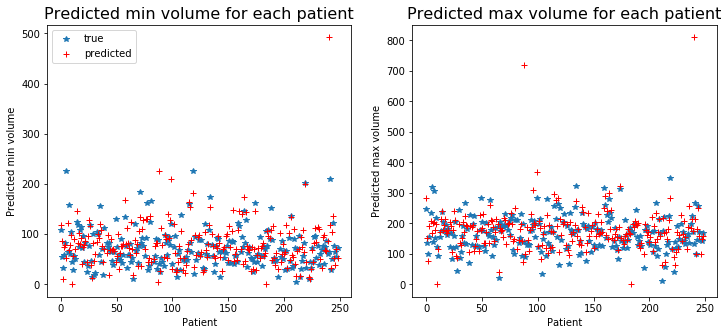

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])

ax1.plot(patient_indices, true_min, '*', label="true")
ax1.plot(patient_indices, min_vols, '+', color='r', label="predicted")
ax1.set_title('Predicted min volume for each patient', fontsize=16)
ax1.set_ylabel('Predicted min volume')
ax1.set_xlabel('Patient')
ax1.legend()
ax2.plot(patient_indices, true_max, '*', label="true")
ax2.plot(patient_indices, max_vols, '+', color='r', label="predicted")
ax2.set_title('Predicted max volume for each patient', fontsize=16)
ax2.set_ylabel('Predicted max volume')
ax2.set_xlabel('Patient')
ax2.legend()
fig.show()

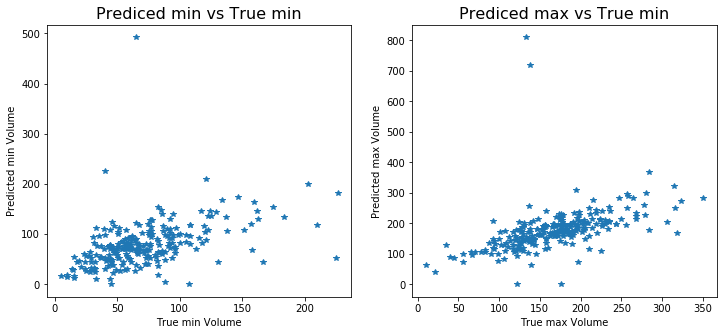

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])

ax1.plot(true_min, min_vols, '*')
ax1.set_title('Prediced min vs True min', fontsize=16)
ax1.set_ylabel('Predicted min Volume')
ax1.set_xlabel('True min Volume')
ax2.plot(true_max, max_vols, '*')
ax2.set_title('Prediced max vs True max', fontsize=16)
ax2.set_ylabel('Predicted max Volume')
ax2.set_xlabel('True max Volume')

fig.show()

In [ ]:
# Correlation Coefficient

corr_max = np.corrcoef(min_vols, true_min)
corr_min = np.corrcoef(max_vols, true_max)

print(corr_max[0,1], "Correlation predicted and true max values")
print(corr_min[0,1], "Correlation predicted and true min values")

0.45310301064616065 Correlation predicted and true max values
0.45319071035029707 Correlation predicted and true min values


In [ ]:
# Create model, least squares fit
#model building
deg = 1
a_min, b_min = np.polyfit(min_vols, true_min, deg)
a_max, b_max = np.polyfit(max_vols, true_max, deg)

# Use model
pred_min = a_min * min_vols + b_min
pred_max = a_max * max_vols + b_max

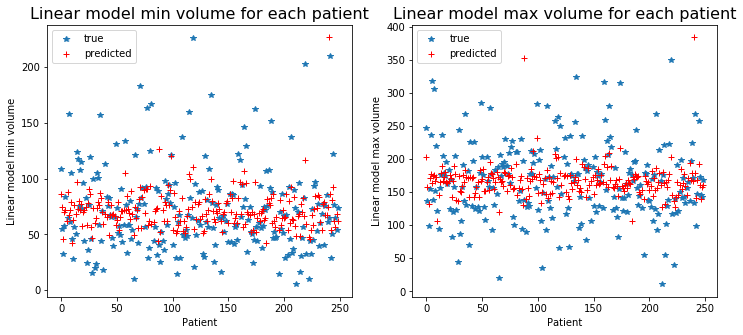

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])

ax1.plot(patient_indices, true_min, '*', label="true")
ax1.plot(patient_indices, pred_min, '+', color='r', label="predicted")
ax1.set_title('Linear model min volume for each patient', fontsize=16)
ax1.set_ylabel('Linear model min volume')
ax1.set_xlabel('Patient')
ax1.legend()

ax2.plot(patient_indices, true_max, '*', label="true")
ax2.plot(patient_indices, pred_max, '+', color='r', label="predicted")
ax2.set_title('Linear model max volume for each patient', fontsize=16)
ax2.set_ylabel('Linear model max volume')
ax2.set_xlabel('Patient')
ax2.legend()

fig.show()

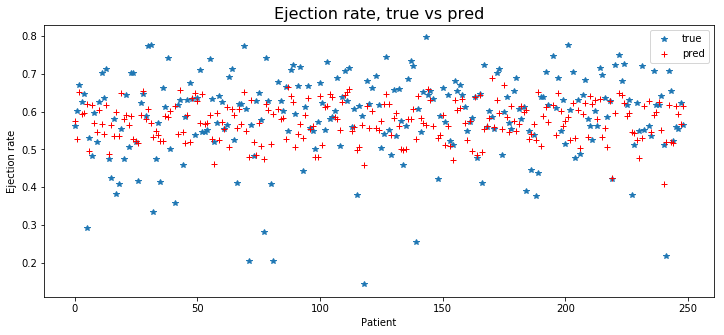

In [ ]:

def ejection_rate(vd, vs):
    "Returns a float between 0 and 1"
    return (vd - vs) / vd

true_ejection = ejection_rate(true_max, true_min)
pred_ejection = ejection_rate(pred_max, pred_min)

fig, ax = plt.subplots(1, 1, figsize=[12,5])

ax.plot(patient_indices, true_ejection, '*', label="true")
ax.plot(patient_indices, pred_ejection, '+', color='r', label="pred")
ax.set_title('Ejection rate, true vs pred', fontsize=16)
ax.set_ylabel('Ejection rate')
ax.set_xlabel('Patient')
ax.legend()

fig.show()

In [ ]:
rmse_min = np.sqrt(((true_min - pred_min)**2).mean())
rmse_max = np.sqrt(((true_max - pred_max)**2).mean())
print("MSE Systole:", rmse_min)
print("MSE Diastole:", rmse_max)

MSE Systole: 34.22199395818715
MSE Diastole: 50.350728573332596


In [ ]:
corr_max = np.corrcoef(pred_min, true_min)
corr_min = np.corrcoef(pred_max, true_max)

print(corr_max[0,1], "Correlation predicted and true max values")
print(corr_min[0,1], "Correlation predicted and true min values")

0.4531030106461608 Correlation predicted and true max values
0.4531907103502972 Correlation predicted and true min values


In [ ]:
def ejection_rate(v_max, v_min): return (v_max - v_min) / v_max

pred_ejections = np.array([ejection_rate(vd, vs) for vd,vs in zip(pred_max, pred_min)])
true_ejections = np.array([ejection_rate(vd, vs) for vd,vs in zip(true_max, true_min)])

rmse_ejection = np.sqrt(((true_ejections- pred_ejections)**2).mean())
print("RMSE Ejection Rate:", rmse_ejection)

RMSE Ejection Rate: 0.10208284283634794


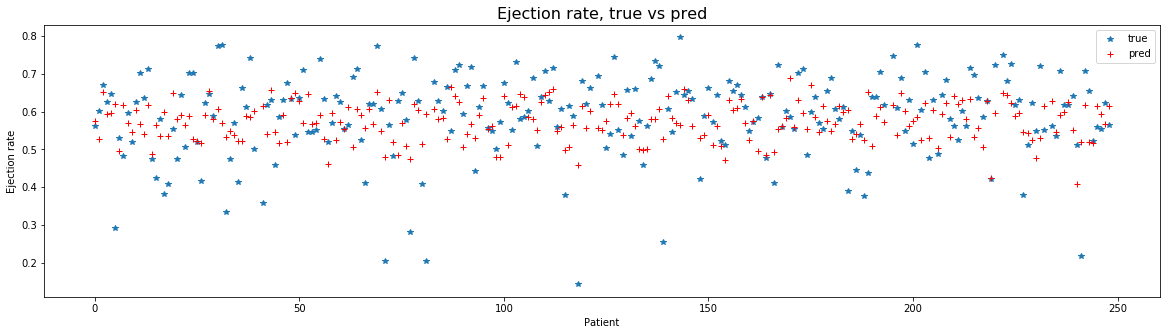

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[20,5])

ax.plot(patient_indices, true_ejections, '*', label="true")
ax.plot(patient_indices, pred_ejections, '+', color='r', label="pred")
ax.set_title('Ejection rate, true vs pred', fontsize=16)
ax.set_ylabel('Ejection rate')
ax.set_xlabel('Patient')
ax.legend()

fig.show()